## Detecting and Classifying Malicious Uniform Resource Locations Using Advanced Machine Learning

In [62]:
#@title Packages
#!pip install -qq itables
#pip install imbalanced-learn==0.7.0

In [63]:
#@title Libraries
from urllib.parse import urlsplit
#from itables import init_notebook_mode
#from google.colab.data_table import DataTable
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

#@title Settings

DataTable.max_columns = 32
init_notebook_mode(all_interactive=True)
sns.set_theme()

In [39]:
#@title Read DataFrame

df = pd.read_csv(r"malicious_phish.csv")
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [40]:
#@title General Info
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


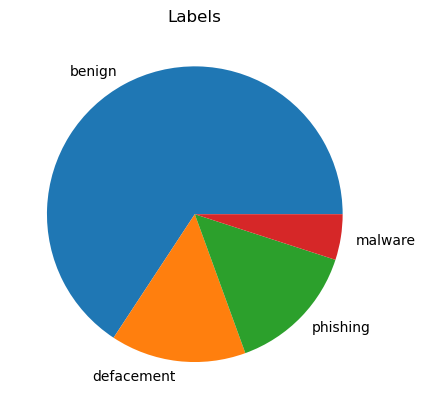

In [42]:
#@title Distribution
plt.figure()

df['type'].value_counts().plot(kind='pie')
plt.title('Labels')
plt.gca().set_ylabel('')
plt.show()

# Preprocessing

In [43]:
#@title Extract Features

df['ext_type'] = df['url'].apply(lambda x: urlsplit(x).path.rsplit('.', 1)[-1] if '.' in urlsplit(x).path else 'None')

value_counts = df['ext_type'].value_counts()
values_to_replace = value_counts.nlargest(8).index

df.loc[~df['ext_type'].isin(values_to_replace), 'ext_type'] = 'None'

df['has_http'] = df['url'].str.contains('http://').astype(int)

df['has_org'] = df['url'].str.contains('org').astype(int)

df['has_query'] = df['url'].str.contains('\?').astype(int)

df['count_routes'] = df['url'].str.replace('http://', '').str.count('/')

df['count_routes'] = df['count_routes'].where(df['count_routes'] <= 4, 4)

In [44]:
df.head()

,url,type,ext_type,has_http,has_org,has_query,count_routes
0,br-icloud.com.br,phishing,None,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,html,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,htm,0,1,0,3
3,http://www.garage-pirenne.be/index.php?option=...,defacement,php,1,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,php,1,0,1,1


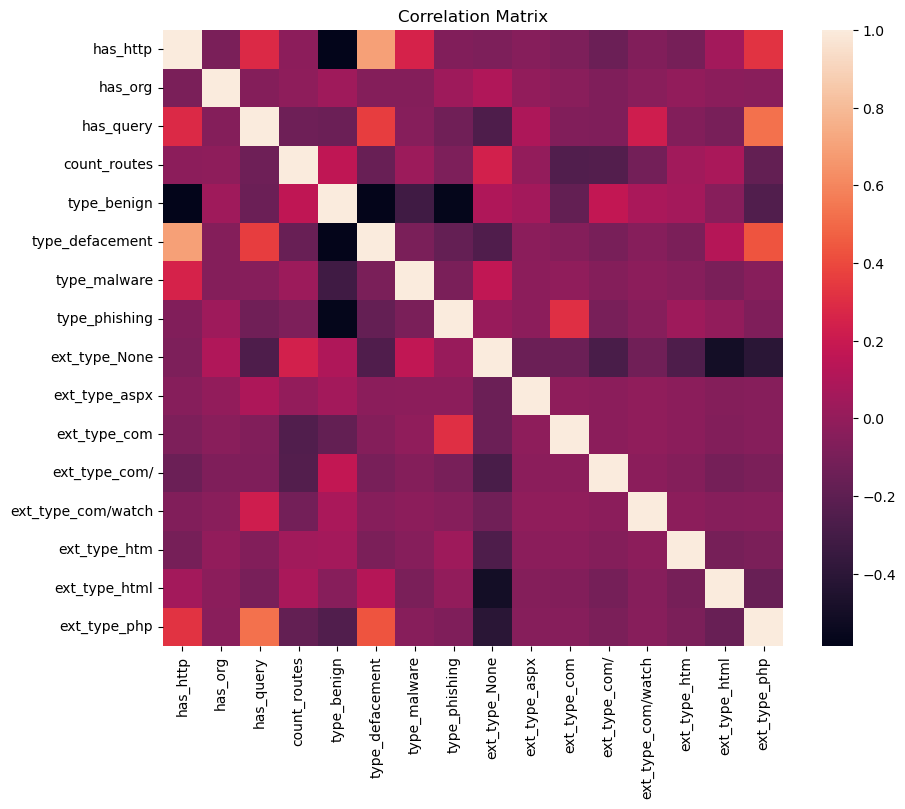

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.get_dummies(df.iloc[:, 1:]).corr())
plt.title('Correlation Matrix')
plt.show()

In [46]:
y_mapping = {
    0:'benign',
    1:'defacement', 
    2:'malware', 
    3:'phishing'
}

df['count_routes'] = df['count_routes'].astype(str)

X,y = pd.get_dummies(df.iloc[:, 2:]), df['type'].replace({v: k for k, v in y_mapping.items()})

In [47]:
df.iloc[:, 2:]

,ext_type,has_http,has_org,has_query,count_routes
0,None,0,0,0,0
1,html,0,0,0,2
2,htm,0,1,0,3
3,php,1,0,1,1
4,php,1,0,1,1
...,...,...,...,...,...
651186,html,0,0,0,3
651187,None,0,0,0,4
651188,None,0,0,0,4
651189,None,0,1,0,2


In [48]:
y

0         3
1         0
2         0
3         1
4         1
         ..
651186    3
651187    3
651188    3
651189    3
651190    3
Name: type, Length: 651191, dtype: int64

In [49]:
X

,has_http,has_org,has_query,ext_type_None,ext_type_aspx,ext_type_com,ext_type_com/,ext_type_com/watch,ext_type_htm,ext_type_html,ext_type_php,count_routes_0,count_routes_1,count_routes_2,count_routes_3,count_routes_4
0,0,0,0,True,False,False,False,False,False,False,False,True,False,False,False,False
1,0,0,0,False,False,False,False,False,False,True,False,False,False,True,False,False
2,0,1,0,False,False,False,False,False,True,False,False,False,False,False,True,False
3,1,0,1,False,False,False,False,False,False,False,True,False,True,False,False,False
4,1,0,1,False,False,False,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,0,0,0,False,False,False,False,False,False,True,False,False,False,False,True,False
651187,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,True
651188,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,True
651189,0,1,0,True,False,False,False,False,False,False,False,False,False,True,False,False


In [51]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Perform random undersampling to balance the classes
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split samples
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

print(pd.value_counts(y_train))

X_train shape is (104064, 16)
y_train shape is (104064,)
X_test shape is (26016, 16)
y_test shape is (26016,)
type
0    26107
3    26075
1    25969
2    25913
Name: count, dtype: int64


In [52]:
#Naive Bayes classifier

In [53]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

# Generate a classification report
report = classification_report(y_test, y_pred)
print("\nNaive Bayes classifier classifiaction report \n",report)

Accuracy: 62.30%

Naive Bayes classifier classifiaction report 
               precision    recall  f1-score   support

           0       0.66      0.53      0.59      6413
           1       0.70      0.76      0.73      6551
           2       0.53      0.84      0.65      6607
           3       0.68      0.36      0.47      6445

    accuracy                           0.62     26016
   macro avg       0.64      0.62      0.61     26016
weighted avg       0.64      0.62      0.61     26016



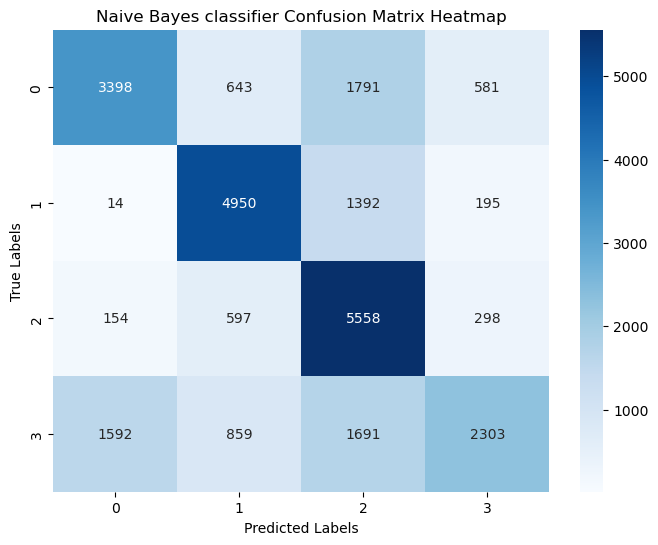

In [55]:
cm=confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Naive Bayes classifier Confusion Matrix Heatmap")
plt.show()

In [56]:
#RandomForestClassifier

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
rf=RandomForestClassifier()

In [59]:
rf.fit(X_train,y_train)

RandomForestClassifier()

In [60]:
# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
cm=confusion_matrix(y_test, y_pred)
print(cm)

# Print the classification report
print("\nRandomForestClassifier Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7109471094710947
[[4523  232  973  685]
 [   0 5398 1111   42]
 [  59  497 5795  256]
 [2297  364 1004 2780]]

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.71      0.68      6413
           1       0.83      0.82      0.83      6551
           2       0.65      0.88      0.75      6607
           3       0.74      0.43      0.54      6445

    accuracy                           0.71     26016
   macro avg       0.72      0.71      0.70     26016
weighted avg       0.72      0.71      0.70     26016



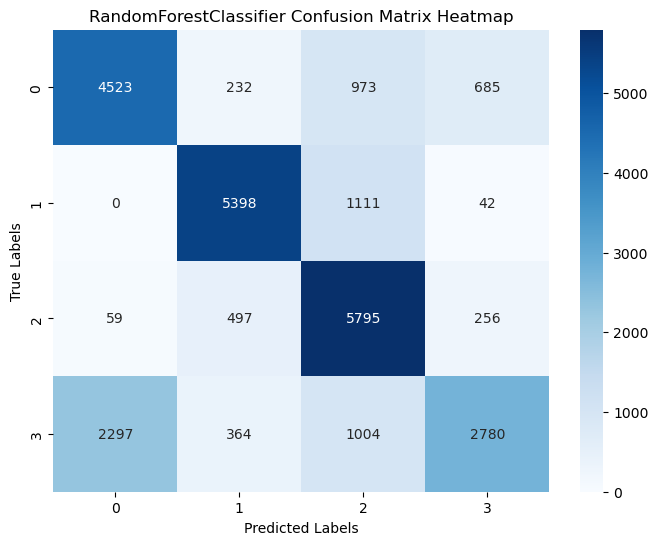

In [61]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("RandomForestClassifier Confusion Matrix Heatmap")
plt.show()